In [1]:
import sys
sys.path.append("..")
from utils.Db import Db
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [2]:
db = Db("../cache")
df = db.get_symbols_as_dataframe(['AAPL'])
df['date_time'] = pd.to_datetime(df['date_time'])

plt.rcParams["figure.figsize"] = [9, 6]
%matplotlib notebook

In [3]:
ewmdf = df[df['date_time'] > datetime.now() - timedelta(days=365)]
ewmdf.index = ewmdf['date_time']
days_12 = ewmdf['adjusted_close'].ewm(span=12).mean()
days_12 = days_12.reset_index()
days_26 = ewmdf['adjusted_close'].ewm(span=26).mean()
days_26 = days_26.reset_index()

macd_line = pd.DataFrame(days_12['adjusted_close'] - days_26['adjusted_close'], columns=['adjusted_close'])
macd_line.index = ewmdf['date_time']
macd_line = macd_line.reset_index()
signal_line = macd_line['adjusted_close'].ewm(span=9).mean()
signal_line = signal_line.reset_index()
macd_hist = macd_line['adjusted_close'] - signal_line['adjusted_close']

<IPython.core.display.Javascript object>


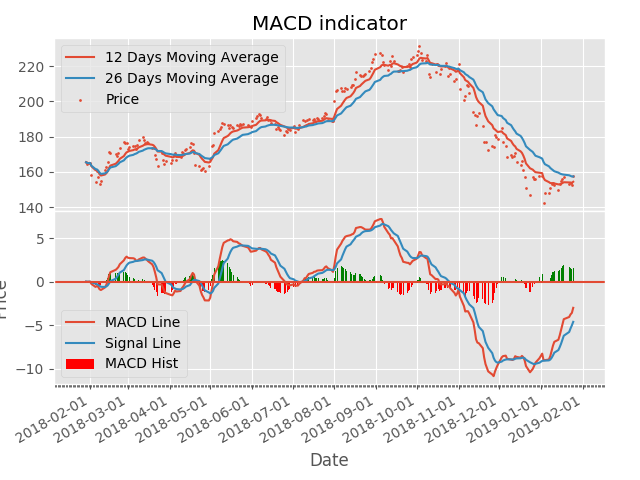

In [4]:
years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
yearsFmt = mdates.DateFormatter('%Y-%m-%d')

scatter_data = ewmdf[['unix_time', 'adjusted_close', 'date_time']].as_matrix()

plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(scatter_data[:, 2], scatter_data[:, 1].tolist(), label='Price', s=2)
ax.plot(days_12['date_time'], days_12['adjusted_close'], label='12 Days Moving Average')
ax.plot(days_26['date_time'], days_26['adjusted_close'], label='26 Days Moving Average')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(yearsFmt)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.title('MACD indicator')
plt.legend()

ax = fig.add_subplot(212, sharex=ax)
ax.plot(days_12['date_time'], macd_line['adjusted_close'], label='MACD Line')
ax.plot(days_12['date_time'], signal_line['adjusted_close'], label='Signal Line')
colors = ["green" if x > 0 else "red" for x in macd_hist]
ax.bar(scatter_data[:, 2], macd_hist, label='MACD Hist', color=colors)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(yearsFmt)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.axhline(0)

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()